# Overview

This example notebook will demonstrate Howso Engine’s ability to handle model drift. Drift occurs when a trained model no longer reflects the desired aspects of reality, leading to poor predictions. Howso Engine can be used to monitor any potential drift by evaluating bias in both new and ongoing models using online learning and interpretability. 

## Step 1: Load the Data

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
import pmlb
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import (
    plot_drift,
    plot_kl_divergence,
)

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

In [2]:
df = pmlb.fetch_data('iris', local_cache_dir='data/pmlb')
df

,sepal-length,sepal-width,petal-length,petal-width,target
0,6.7,3.0,5.2,2.3,2
1,6.0,2.2,5.0,1.5,2
2,6.2,2.8,4.8,1.8,2
3,7.7,3.8,6.7,2.2,2
4,7.2,3.0,5.8,1.6,2
...,...,...,...,...,...
145,5.0,3.5,1.6,0.6,0
146,5.4,3.9,1.7,0.4,0
147,5.1,3.4,1.5,0.2,0
148,5.0,3.6,1.4,0.2,0


## Step 2: Simulate Data Drift

Model drift occurs when the model that has been trained no longer reflects the desired aspects of reality. In this case, we will sample from the data in such a way that certain targets are much less likely to appear in our test and observation sets than in the training set. This will simulate model drift and allow us to demonstrate Howso Engine.

In [3]:
df_biased = df[df['target'].isin([1,2])]
df_train = df_biased.sample(frac=0.5)
df_test_no_drift = df_biased[~df_biased.isin(df_train)].dropna()
df_test_drift = df[~df.isin(df_biased)].dropna()
df_test_drift.loc[df_test_drift.sample(frac=0.2).index, "target"] = np.nan

df_test = pd.concat([df_test_no_drift, df_test_drift])

print(len(df_train), len(df_test))
display(df_train.target.value_counts())
display(df_test_no_drift.target.value_counts())
display(df_test_drift.target.value_counts())

50 100


target
1    27
2    23
Name: count, dtype: int64

target
2.0    27
1.0    23
Name: count, dtype: int64

target
0.0    40
Name: count, dtype: int64

## Step 3: Map Data

Map the data to feature attributes and ensure they are mapped correctly.

In [4]:
features = infer_feature_attributes(df)
feature_names = df.columns.tolist()
action_features = feature_names[-1:]
context_features = feature_names[:-1]

features

{'sepal-length': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 2.7, 'max': 20.1}},
 'sepal-width': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 7.4}},
 'petal-length': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 7.4}},
 'petal-width': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.0, 'max': 2.7}},
 'target': {'type': 'nominal',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}}}

## Step 4: Train the non-Howso Model

The non-Howso model will be trained on the training set created above. The training order and the predicted value will be recorded as inputs to the Howso model to help monitor drift.

In [5]:
gb = GradientBoostingClassifier()
gb.fit(df_train[context_features].values, df_train[action_features].values.reshape(-1))

# Use predicted features to inform Howso Engine

df_test['target'] = df_test['target']
df_test = df_test.reset_index(drop=True)
df_test = df_test.reset_index()

df_train = df_train.reset_index(drop=True)
df_train = df_train.reset_index()

df_test

,index,sepal-length,sepal-width,petal-length,petal-width,target
0,0,7.2,3.0,5.8,1.6,2.0
1,1,5.7,2.9,4.2,1.3,1.0
2,2,6.3,3.4,5.6,2.4,2.0
3,3,6.3,2.9,5.6,1.8,2.0
4,4,5.8,2.8,5.1,2.4,2.0
...,...,...,...,...,...,...
95,95,5.0,3.5,1.6,0.6,0.0
96,96,5.4,3.9,1.7,0.4,0.0
97,97,5.1,3.4,1.5,0.2,0.0
98,98,5.0,3.6,1.4,0.2,0.0


## Step 5: Train the Howso Model

The Howso model will be trained on the modified data set trained above. We leverage online learning to record explanations with each case that is trained. We make sure to use the predicted target from the non-Howso model as well as the index to diversify the ways in which we can monitor the model. The index allows us to determine whether or not the time at which a given case was trained is important for prediction, which could indicate drift, while the predicted target allows us to note disagreements between the two models.

In [6]:
# Create and train REACTOR
mismatch_counts = []

features = infer_feature_attributes(df_test)
new_context_features = None

familiarity_conviction_dp = []
familiarity_conviction_gb = []
mda_interpret = []
mda_explain = []

# Create trainee and turn on auto-analyze
t = engine.Trainee("Engine - Drift Monitoring Recipe", features, overwrite_existing=True)
t.train(df_train)
t.analyze()
t.set_auto_analyze_params(analyze_threshold=1, auto_analyze_enabled=True)
for idx, case in df_test.iterrows():
    # Define which details we want from the Howso model
    details = {
        'feature_mda': True
    }
    
    # Predict using the gradient booster
    pred_gb = gb.predict(case[context_features].values.reshape(1, -1))[0]
    gb_case = case.copy()
    gb_case.target = pred_gb
    
    # Define the updates context features
    if new_context_features is None:
        new_context_features = [col for col in case.index if col not in action_features]
        print(new_context_features)
        
    # React on the new case
    result = t.react(case[new_context_features].values.reshape(1, -1),
                     action_features=action_features,
                     context_features=new_context_features,
                     details=details)
    action = result['action']
    explanation = result['details']
    
    # Train on the new case
    t.train([case.values.tolist()], features=df_test.columns.tolist())
    
    # Store the Howso prediction
    pred_dp = action.iloc[0, 0]
    
    # Compute familiarity conviction for case
    f_conv = t.react_group(new_cases=[[case.values.tolist()], [gb_case.values.tolist()]], features=df_test.columns.tolist())
    f_conv_dp = f_conv['familiarity_conviction_addition'].iloc[0]
    f_conv_gb = f_conv['familiarity_conviction_addition'].iloc[1]
    familiarity_conviction_dp.append(f_conv_dp)
    familiarity_conviction_gb.append(f_conv_gb)
    
    if pred_dp != pred_gb:
        mismatch_counts.append(1)
    else:
        mismatch_counts.append(0)
        
    if pred_dp != pred_gb and f_conv_dp < 0.5 * np.mean(familiarity_conviction_dp) and idx > 30:
        print(f"Case {idx} is anomalous.")
        case['pred'] = pred_gb
        display(case)
        dp_importances = [val for key, val in explanation['feature_mda'][0].items() if key in context_features]
        gb_importances = gb.feature_importances_.tolist()
        print(f"ENGINE feature importance: {[context_features[i] for i in np.argpartition(dp_importances, -3)[-3:]]}")
        print(f"MODEL feature importance  : {[context_features[i] for i in np.argpartition(gb_importances, -3)[-3:]]}")
        print("\n=====\n")
        
    # Get interpret MDA
    details = {
        'robust_influences': True,
        'feature_mda_ex_post': True
    }
    result = t.react(case[new_context_features].values.reshape(1, -1), 
                     actions=[[case.target]],
                     action_features=action_features,
                     context_features=new_context_features,
                     details=details)
    action = result['action']
    explanation = result['details']
    mda_interpret.append(explanation['feature_mda_ex_post'][0])
    
    # Get explain MDA
    result = t.react(case[new_context_features].values.reshape(1, -1), 
                     actions=[[gb_case.target]],
                     action_features=action_features,
                     context_features=new_context_features,
                     details=details)
    action = result['action']
    explanation = result['details']
    mda_explain.append(explanation['feature_mda_ex_post'][0])

['index', 'sepal-length', 'sepal-width', 'petal-length', 'petal-width']


Case 53 is anomalous.


index           53.0
sepal-length     4.8
sepal-width      3.1
petal-length     1.6
petal-width      0.2
target           0.0
pred             1.0
Name: 53, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====

Case 54 is anomalous.


index           54.0
sepal-length     5.0
sepal-width      3.3
petal-length     1.4
petal-width      0.2
target           0.0
pred             1.0
Name: 54, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 55 is anomalous.


index           55.0
sepal-length     5.0
sepal-width      3.0
petal-length     1.6
petal-width      0.2
target           0.0
pred             1.0
Name: 55, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 57 is anomalous.


index           57.0
sepal-length     5.1
sepal-width      3.5
petal-length     1.4
petal-width      0.3
target           0.0
pred             1.0
Name: 57, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====

Case 58 is anomalous.


index           58.0
sepal-length     5.7
sepal-width      3.8
petal-length     1.7
petal-width      0.3
target           NaN
pred             1.0
Name: 58, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 60 is anomalous.


index           60.0
sepal-length     5.1
sepal-width      3.8
petal-length     1.9
petal-width      0.4
target           NaN
pred             1.0
Name: 60, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 62 is anomalous.


index           62.0
sepal-length     5.4
sepal-width      3.9
petal-length     1.3
petal-width      0.4
target           NaN
pred             1.0
Name: 62, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 64 is anomalous.


index           64.0
sepal-length     4.8
sepal-width      3.4
petal-length     1.9
petal-width      0.2
target           NaN
pred             1.0
Name: 64, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 67 is anomalous.


index           67.0
sepal-length     4.5
sepal-width      2.3
petal-length     1.3
petal-width      0.3
target           0.0
pred             1.0
Name: 67, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====

Case 68 is anomalous.


index           68.0
sepal-length     5.1
sepal-width      3.8
petal-length     1.5
petal-width      0.3
target           NaN
pred             1.0
Name: 68, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 78 is anomalous.


index           78.0
sepal-length     5.2
sepal-width      4.1
petal-length     1.5
petal-width      0.1
target           NaN
pred             1.0
Name: 78, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 85 is anomalous.


index           85.0
sepal-length     5.1
sepal-width      3.3
petal-length     1.7
petal-width      0.5
target           NaN
pred             1.0
Name: 85, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 89 is anomalous.


index           89.0
sepal-length     4.9
sepal-width      3.0
petal-length     1.4
petal-width      0.2
target           NaN
pred             1.0
Name: 89, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



Case 94 is anomalous.


index           94.0
sepal-length     4.8
sepal-width      3.0
petal-length     1.4
petal-width      0.1
target           NaN
pred             1.0
Name: 94, dtype: float64

ENGINE feature importance: ['sepal-width', 'sepal-length', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-width', 'petal-width']

=====



## Step 6: "Deploy" the non-Howso Model

We iterate through the test set, getting predictions from both the non-Howso and Howso model. Explanations are recorded at each step, and anomalous cases are brought to the forefront including feature importance and predictions. The Howso model learns from this information as each new case is predicted. The non-Howso model is not updated online.

## The beginning of model drift is made very clear by the drop in familiarity conviction.

This demo was created in such a way to make the effects of drift very obvious. It may be more subtle with a real-world model.

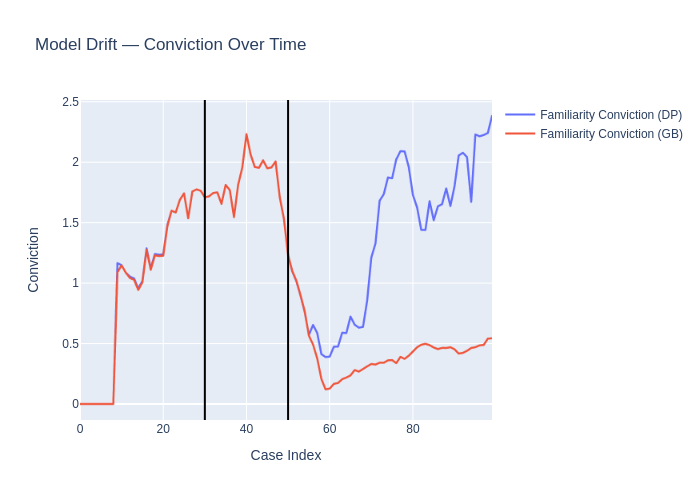

In [7]:
f_conv_df = pd.DataFrame(familiarity_conviction_dp, columns=["Familiarity Conviction (DP)"])
f_conv_df["Familiarity Conviction (GB)"] = familiarity_conviction_gb

plot_drift(f_conv_df, line_positions=[30, len(df_test_no_drift)])

In [8]:
# calculate delta conviction between Howso vs. GB model
conv_delta = f_conv_df['Familiarity Conviction (DP)'] - f_conv_df['Familiarity Conviction (GB)']

# calculate average delta for the latter portion of the data (after drift occurred)
avg_delta = conv_delta[int(len(conv_delta) * 2 / 3):len(conv_delta)].mean()

## We can also count the number of times the models disagree with each other

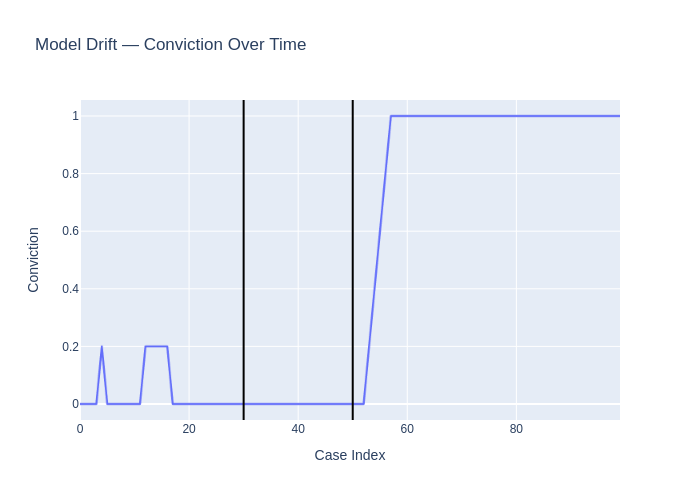

In [9]:
mismatch_count_df = pd.DataFrame(mismatch_counts, columns=["Prediction Deviation"])

plot_drift(mismatch_count_df, line_positions=[30, len(df_test_no_drift)], rolling_window=5)

In [10]:
# extract the series
mismatch_series = mismatch_count_df['Prediction Deviation']

# calculate before and after drift mismatch
after_drift = mismatch_series.iloc[int(len(mismatch_series) * 2 / 3):].mean()
before_drift = mismatch_series.iloc[:int(len(mismatch_series) * 1 / 3)].mean()

avg_pred_mismatch = after_drift - before_drift

# Another method is monitor changes in feature importance between the models

In [11]:
# remove situations when both features are 0 or negative
def check_case(s1, s2):
    for i, j in zip(s1, s2):
        if (i <=0) and (j <=0):
            return True
    return False

# clean up mean-decrease-accuracy for kl-divergence calculation
def clean_mda(df_int, df_exp):
    ind_for_remove = []
    
    # Store all zero values
    ind_zeros = []
    
    for i in df_int.index:
        if check_case(df_int.loc[i, :], df_exp.loc[i, :]):
            ind_for_remove.append(i)

        # If everything are zeros, set kl-divergence = 0 later on
        if (df_int.loc[i, :] == 0).all() and (df_exp.loc[i, :] == 0).all():
            ind_zeros.append(i)
    
    df_int_clean = df_int.drop(ind_for_remove)
    df_exp_clean = df_exp.drop(ind_for_remove)
    
    # if still negative, set to zero
    df_int_clean[df_int_clean < 0] = 0
    df_exp_clean[df_exp_clean < 0] = 0

    # if there are any all zero records left, set to inf during kl-divergence calculation
    ind_inf = []
    ind_for_remove = []
    for i in df_int_clean.index:
        if (df_int_clean.loc[i, :] == 0).all() or (df_exp_clean.loc[i, :] == 0).all():
            ind_for_remove.append(i)
            ind_inf.append(i)

    df_int_clean = df_int_clean.drop(ind_for_remove)
    df_exp_clean = df_exp_clean.drop(ind_for_remove)
            
    return df_int_clean, df_exp_clean, ind_zeros, ind_inf

In [12]:
mda_int = pd.DataFrame(mda_interpret)
mda_exp = pd.DataFrame(mda_explain)

mda_int, mda_exp, ind_zeros, ind_inf = clean_mda(mda_int, mda_exp)

kl_div = pd.Series(entropy(pk=mda_int, qk=mda_exp, axis=1), index=mda_int.index)

# Using zeros where all values = 0
for i in ind_zeros:
    kl_div.loc[i] = 0
    
for i in ind_inf:
    kl_div.loc[i] = np.inf

kl_div = kl_div.sort_index()

non_inf = kl_div[~(kl_div == np.inf)]
inf = kl_div[kl_div == np.inf]

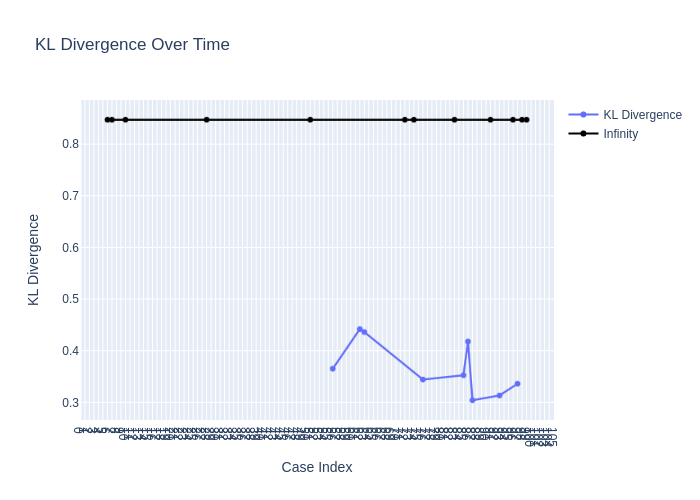

In [13]:
plot_kl_divergence(kl_div)

In [14]:
# calculate the average kl-divergence before and after drift
kl_before_drift = non_inf[:int(len(non_inf) * (1 / 3))].sum()
kl_after_drift = non_inf[int(len(non_inf) * (2 / 3)):].sum()

kl_diff = kl_after_drift - kl_before_drift
kl_diff

0.1392316352034575